In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from scipy.io import loadmat
from sklearn.preprocessing import MinMaxScaler
import time
import torch
import torch.nn as nn
import pickle
from os import path

import utilities as util
import models

In [61]:
params = {'id': 'toy',
          'path2data': '../data/ID02_1h.mat',
          # model parameters ------------------------
          'channel_size': 8,
          'hidden_size': 0,
          'lambda': 0.5,
          'non-linearity': 'tanh',
          'bias': False,
          # train parameters -------------------------
          'sample_size': 100,
          'window_size': 10,
          'normalization': True,
          'epochs': 20,
          'lr_decay': 7}

In [5]:
t = torch.ones(4, requires_grad=True)
t[:2] = 0.5
print(t)

tensor([0.5000, 0.5000, 1.0000, 1.0000], grad_fn=<CopySlices>)


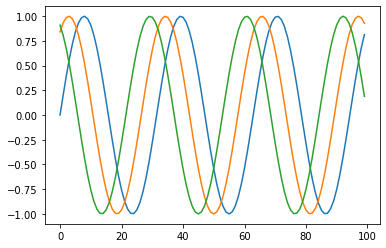

torch.Size([10, 3])


In [48]:
# Make data
data = np.zeros([params['sample_size'],3])
maxval = 20
linear = np.arange(0, maxval, maxval/params['sample_size'])
data[:, 0] = np.sin(linear)
data[:, 1] = np.sin(linear+1)
data[:, 2] = np.sin(linear+2)

plt.figure()
plt.plot(data)
plt.show()

# To tensor
data = torch.FloatTensor(data)

# Windowing
X_train = []
for i in range(data.shape[0] - params['window_size']):
    X_train.append(data[i:i + params['window_size'], :])
    
print(X_train[0].shape)

In [62]:
X_train, X_test = util.data_loader(params=params)

In [63]:
class FRNN_experimental(nn.Module):
    def __init__(self, params: dict):
        super().__init__()
        # Parameters
        self.hidden_size = params['hidden_size']
        self.visible_size = params['channel_size']
        self.full_size = self.visible_size + self.hidden_size
        # Create FC layer
        self.W = nn.Linear(self.full_size, self.full_size, bias=params['bias'])
        # Define non-linearity
        exec_str = 'self.phi = torch.' + params['non-linearity']
        exec(exec_str)
        # Make gate Lambda
        self.recurrence = params['lambda']
        self.Lambda = torch.cat((torch.ones(self.visible_size, self.visible_size) * self.recurrence,
                                 torch.ones(self.visible_size, self.hidden_size)), 1)
        for idx in range(self.visible_size):
            self.Lambda[idx, idx] = 1

    def forward(self, X):
        # Initialize r and i nodes
        R = torch.zeros((self.visible_size, self.full_size), dtype=torch.float32)
        I = torch.zeros((self.visible_size, self.full_size), dtype=torch.float32)
        # Forward path
        for t in range(X.shape[0]):
            I[:, :self.visible_size] = X[t, :].repeat(self.visible_size).view(-1, self.visible_size)
            U = torch.mul(self.Lambda, self.W(R)) + torch.mul((1 - self.Lambda), I)
            R = self.phi(U)
            #R = (1 / (1 + torch.exp(-U*2)))
        return U


In [64]:
# Define model, criterion and optimizer
model = FRNN_experimental(params)
criterion = nn.MSELoss(reduction='none')
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training
temp_loss = np.zeros([len(X_train), params['channel_size']])
epoch_loss = np.zeros([params['epochs'], params['channel_size']])
epoch_grad_norm = np.zeros(params['epochs'])
temp_grad_norm = np.zeros(len(X_train))

start_time = time.time()
for epoch in range(params['epochs']):
    if epoch is not 0 and epoch % params['lr_decay'] is 0:
        for param_group in optimizer.param_groups:
            param_group['lr'] = param_group['lr'] / 2
    for T, X in enumerate(X_train):
        optimizer.zero_grad()
        prediction = model(X)
        diag_prediction = torch.diag(prediction[:, :model.visible_size])
        loss = criterion(diag_prediction, X[-1, :])
        temp_loss[T, :] = loss.detach()
        torch.autograd.backward(loss.mean())
        optimizer.step()
        for p in model.parameters():
            temp_grad_norm[T] = p.grad.data.norm(2).item()
    epoch_grad_norm[epoch] = np.mean(temp_grad_norm)
    epoch_loss[epoch, :] = np.mean(temp_loss, axis=0)
    print(f'Epoch: {epoch} | Loss: {np.mean(temp_loss):.4}')

total_time = time.time() - start_time
print(f'Time [min]: {total_time / 60:.3}')

# Make optimizer evaluation dictionary
eval_optimization = {'id': params['id'],
                     'loss': epoch_loss,
                     'grad_norm': epoch_grad_norm}


Epoch: 0 | Loss: 0.2564
Epoch: 1 | Loss: 0.1757
Epoch: 2 | Loss: 0.1084
Epoch: 3 | Loss: 0.06754
Epoch: 4 | Loss: 0.05192
Epoch: 5 | Loss: 0.04743
Epoch: 6 | Loss: 0.04577
Epoch: 7 | Loss: 0.04305
Epoch: 8 | Loss: 0.04265
Epoch: 9 | Loss: 0.04226
Epoch: 10 | Loss: 0.04189
Epoch: 11 | Loss: 0.04153
Epoch: 12 | Loss: 0.04118
Epoch: 13 | Loss: 0.04083
Epoch: 14 | Loss: 0.03958
Epoch: 15 | Loss: 0.03942
Epoch: 16 | Loss: 0.03925
Epoch: 17 | Loss: 0.03908
Epoch: 18 | Loss: 0.0389
Epoch: 19 | Loss: 0.03873
Time [min]: 0.0929


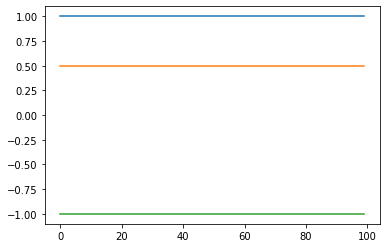

torch.Size([10, 3])


In [43]:
# Make data
data2 = np.ones([params['sample_size'], 3])
"""
maxval = 20
linear = np.arange(0, maxval, maxval/params['sample_size'])
"""
#data2[:, 0] = np.sin(linear)
data2[:, 1] = data2[:, 0]*0.5
data2[:, 2] = data2[:, 0]*(-1)


plt.figure()
plt.plot(data2)
plt.show()

# To tensor
data2 = torch.FloatTensor(data2)

# Windowing
X_train2 = []
for i in range(data2.shape[0] - params['window_size']):
    X_train2.append(data2[i:i + params['window_size'], :])
    
print(X_train2[0].shape)

In [65]:
# Evaluate model
model.eval()

with torch.no_grad():
    test_pred = np.zeros((len(X_train), params['channel_size']))
    test_true = np.zeros((len(X_train), params['channel_size']))
    predictions = np.zeros((len(X_train), params['channel_size'], params['channel_size']+params['hidden_size']))
    for T, X in enumerate(X_train):
        pred = model(X)
        predictions[T,:,:] = pred.numpy()
        diag_prediction = torch.diag(pred[:, :model.visible_size])
        test_pred[T, :] = diag_prediction.numpy()
        test_true[T, :] = X[-1, :].numpy()

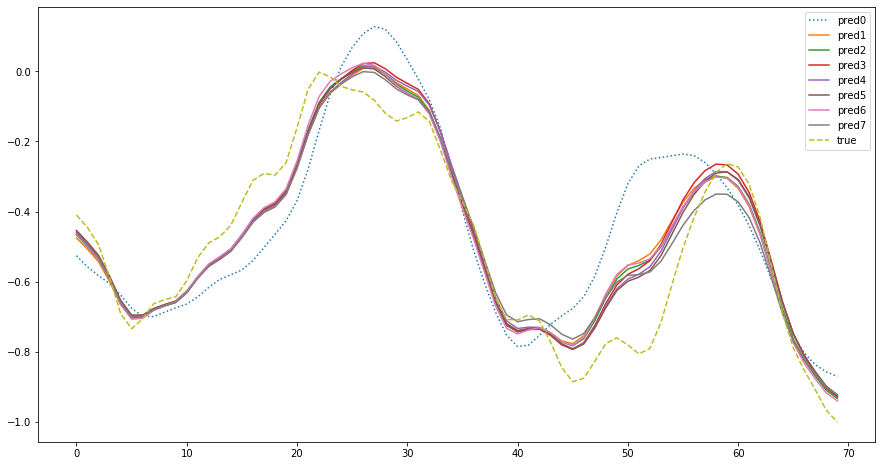

In [75]:
plt.figure(figsize=(15,8))
lookat = 0
for i in range(8):
    label = 'pred' + str(i)
    if i is lookat:
        ls = ':'
    else:
        ls = '-'
    plt.plot(predictions[:, i, lookat], label=label, ls=ls)

plt.plot(test_true[:, lookat], label='true', ls='--')
plt.legend()

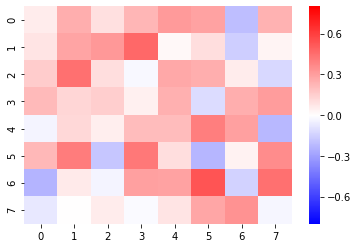

In [67]:
W = model.W.weight.data.numpy()
sns.heatmap(W, cmap='bwr', vmax=.8, vmin=-.8)